In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'
import matplotlib.ticker as mticker
import radical.entk as re

In [2]:
sdir = '../data/raw/'
sids = ['re.session.login5.lei.018358.0000']

In [3]:
s = ra.Session(sdir+sids[0], 'radical.pilot')
p = s.filter(etype='pilot', inplace=False)
u = s.filter(etype='unit', inplace=False)
t = s.filter(etype='task', inplace=False)
w = s.filter(etype='pipeline', inplace=False)

session loaded
session loaded
session loaded
session loaded
session loaded


# Counters

In [4]:
# name of the session
sid = s._sid

# name of the resources to which batch jobs have been submitted
pid = p.list('uid')
presource = p.get(uid=pid)[0].description['resource']

# Number of batch jobs submitted
npilot = len(p.get())

# List of batch jobs ID as seen by RADICAL-Cybertools
p_ids = p.get()

# Number of batch jobs that become active
npilot_active = len(p.timestamps(state='PMGR_ACTIVE'))

# Number of hardware threads of a specific batch job (the first one of the list above)
ncores = p.get(uid=pid)[0].description['cores']

# Number of gpus of a specific batch job (the first one of the list above)
ngpus = p.get(uid=pid)[0].description['gpus']

# Number of tasks executed
nunit = len(u.get())

# Number of tasks successfully executed
nunit_done    = len(u.timestamps(state='DONE'))

# Number of failed tasks
nunit_failed  = len(u.timestamps(state='FAILED'))

# ncore_active  = None     # #active cores
# punit =     # #units executed

In [5]:
print('Number of requested cores: %i' % (ncores/4))
print('Number of requested GPUs: %s' % ngpus)
print('Number of nodes asked by ENTK: %i' % (ncores/168))
print('Number of tasks executed by EnTK: %i' % nunit)
print('Number of tasks successfully executed by EnTK: %i' % nunit_done)
print('Number of failed tasks: %i' % nunit_failed)

Number of requested cores: 2688
Number of requested GPUs: 384
Number of nodes asked by ENTK: 64
Number of tasks executed by EnTK: 1
Number of tasks successfully executed by EnTK: 0
Number of failed tasks: 1


# Durations

In [6]:
p0 = p.get(uid=pid)[0]

# total executon time of the workflow
ttc   = p0.duration(event=[{ru.EVENT: 'state', ru.STATE: rp.NEW},
                           {ru.EVENT: 'state', ru.STATE: rp.DONE}])

# time spent in the queue by the first batch job submitted
ttq_p = p0.duration(event=[{ru.EVENT: 'state', ru.STATE: rp.PMGR_ACTIVE_PENDING},
                           {ru.EVENT: 'state', ru.STATE: rp.PMGR_ACTIVE}])

# time taken by EnTK to execute all the workflow
ttx_w =  w.duration(event=[{ru.EVENT: 'state', ru.STATE: re.states.SCHEDULING},
                           {ru.EVENT: 'state', ru.STATE: re.states.DONE}])

# total time spent executing user's tasks
ttx_u =  u.duration(event=[{ru.EVENT: 'cu_exec_start', ru.STATE: None },
                           {ru.EVENT: 'cu_exec_stop' , ru.STATE: None}])


# execution time of the first batch job executed
ttx_p = p0.duration(event=[{ru.EVENT: 'state', ru.STATE: rp.PMGR_ACTIVE},
                           [{ru.EVENT: 'state', ru.STATE: rp.DONE},
                           {ru.EVENT: 'state', ru.STATE: rp.FAILED},
                           {ru.EVENT: 'state', ru.STATE: rp.CANCELED}]])

# time taken by EnTK to submit all tasks
sub_t =  t.duration(event=[{ru.EVENT: 'state', ru.STATE: re.states.SCHEDULING},
                           {ru.EVENT: 'state', ru.STATE: re.states.SUBMITTING}])

# time taken by EnTK to execute all tasks
ttx_t =  t.duration(event=[{ru.EVENT: 'state', ru.STATE: re.states.SUBMITTING},
                           [{ru.EVENT: 'state', ru.STATE: re.states.COMPLETED},
                            {ru.EVENT: 'state', ru.STATE: re.states.CANCELED},
                            {ru.EVENT: 'state', ru.STATE: re.states.FAILED}]])

In [7]:
print('Application execution time: %i' % ttc)
print('Queue time: %i' % ttq_p)
print('Tasks execution time: %i' % ttx_u)

Application execution time: 8658
Queue time: 8364
Tasks execution time: 68


# Overheads

In [8]:
# radical overheads
ovh_rtc = ttx_w-ttx_u

In [9]:
print('RADICAL-Cybertools overhead: %i' % ovh_rtc)

RADICAL-Cybertools overhead: 34


# Plots

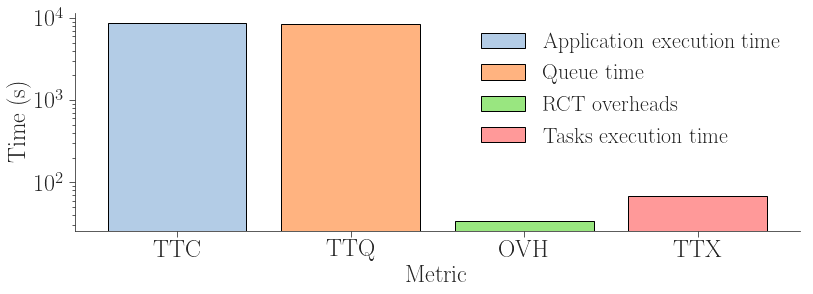

In [10]:
fig, ax = fig_setup(figsize=(13,4))

ax.bar(x = 'TTC', height = ttc,     color = tableau20[1])
ax.bar(x = 'TTQ', height = ttq_p,   color = tableau20[3])
ax.bar(x = 'OVH', height = ovh_rtc, color = tableau20[5])
ax.bar(x = 'TTX', height = ttx_u,   color = tableau20[7])

ax.legend(('Application execution time', 'Queue time', 'RCT overheads', 'Tasks execution time'), loc='upper right', shadow=True)
ax.set_xlabel('Metric')
ax.set_ylabel('Time (s)')
ax.set_yscale('log')